MLPregression(
  (input): Linear(in_features=3, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


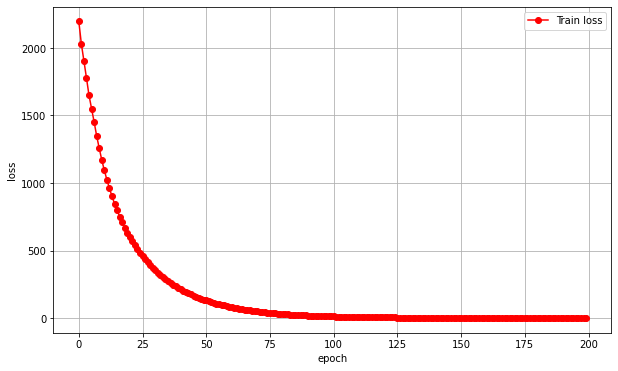

tensor([4.8498e-02, 1.5705e-01, 8.0261e+00,  ..., 5.9470e-01, 4.3683e+01,
        1.6505e+02])
tensor([7.8261e-02, 1.4191e-02, 8.2516e+00,  ..., 3.2492e-01, 4.2960e+01,
        1.6486e+02], dtype=torch.float64)


In [3]:
import numpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt

data=pd.read_excel('C:/Users/XHM/Desktop/data/TFT/vg_train.xlsx',engine='openpyxl')
#data['Vg']=data['Vg'].apply(np.log) 
all_input=data[['Vg','Vd','W/L']].values
all_output=data['Id']
minmax=preprocessing.MinMaxScaler()
#all_output=minmax.fit_transform(data['Idrain'].values.reshape(-1,1))

(x_train,x_test,y_train,y_test)=train_test_split(all_input,all_output,train_size=0.8,
                                                 random_state=0)

#标准化处理

#x_train_s=minmax.fit_transform(x_train)
#x_test_s=minmax.fit_transform(x_test)



#数据类型处理
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.values)
test_xt=torch.from_numpy(x_test.astype(np.float32))
test_yt=torch.from_numpy(y_test.values)

#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt.float())
test_data=Data.TensorDataset(test_xt,test_yt.float())

train_loader=Data.DataLoader(dataset=train_data,batch_size=64,shuffle=True,num_workers=0)


# In[153]:


#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        self.input=nn.Linear(in_features=3,out_features=15,bias=True)
        #定义第二个隐藏层
        self.hidden2=nn.Linear(15,20)
        #回归预测层
        self.predict=nn.Linear(20,1)
    def forward(self,x):
        x=torch.sigmoid(self.input(x))
        x=torch.sigmoid(self.hidden2(x))
        output=self.predict(x)
        return output[:,0]
mlpreg=MLPregression()

#mlpreg.load_state_dict(torch.load('C:/Users/XHM/LEVIST/DIST/TFT_init.pth'))

print(mlpreg)

#定义优化器
optimizer=torch.optim.Adam(mlpreg.parameters(),lr=0.004)
loss_func=nn.MSELoss()
train_loss_all=[]
for epoch in range(200):
    train_loss=0
    train_num=0
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        #print(output)
        #print(test_yt)
        train_num+=b_x.size(0)
    train_loss_all.append(train_loss/train_num)

plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#预测

pre_y=mlpreg(test_xt)
print(pre_y.data)
print(test_yt)


In [4]:
datapre=pd.read_excel('C:/Users/XHM/Desktop/data/TFT/vg_train.xlsx',engine='openpyxl')
x_1=datapre[['Vg','Vd','W/L']].values

#标准化处理

#数据类型处理
train_1=torch.from_numpy(x_1.astype(np.float32))
pre=mlpreg(train_1)

pre=pre.detach().numpy()
inputframe = pd.DataFrame(x_1,columns=['Vg','Vd','W/L'])    #预测的输入
yframe=pd.DataFrame({'Idrain_pre':pre})    #预测的y

inputframe.to_csv('C:/Users/XHM/Desktop/data/Vg_archi.csv',index=False,sep=',')
yframe.to_csv(r'C:/Users/XHM/Desktop/data/Vg_archi.csv',mode='a',sep=',')
